## Cost optimization contd.

### 2. strike a balance between scheduling too much or less by solving flexible integer programming model. 

Another method of tackling under/over utilization and cost optimization is by accepting flexibility in terms of understaffing in the agent-scheduling model without compromising the accepted level of service. That is, assigning fewer agents than what is necessary, but the anticipated total understaffing for the entire day must not go over a predetermined threshold. We are curious to check if assigning less agents at some periods to assist in fulfiling back-office work like emails would not affect expected service levels at those periods. For this, we are considering model proposed by Smriglio et al  without the penalty costs.

\begin{align}
	\textit{Min} \qquad& \sum_{j=1}^{3} c_j x_j \qquad \qquad \qquad \qquad \nonumber\\
	\text{s.t} \qquad& \sum_{j=1}^{3} a_{tj} x_j + U_t - O_t = b_t \quad\nonumber\\
	&\sum_{t=1}^{49}U_t \leq 5\%\sum_{t=1}^{49}b_t\nonumber\\
	&t\in T, \; x_j, U_t, O_t \in Z_{n}^{+}
	\label{flexible model2}
\end{align}
where <br>
$c_j $ : Salary of agent assigned to shift $j$ <br>
$x_j $ : Agents assigned to shift $j$ <br>
$U_t $ : Understaffing at period $t$ <br>
$O_t $ : Overstaffing at period $t$ <br>
$b_t $ : Staffing level at period $t$

\begin{eqnarray*}
	a_{tj}  =  \left\{
	\begin{array}{lr}
		1, \;\;  \text{if shift j covers t}\\
		0, \;\;  otherwise
	\end{array}\right.
\end{eqnarray*} 

In addition to the flexible model, we are going to impose the following boundries on individual variable $U_t$ as follows; <br> we categorize staffing requirement corresponding to call volume at each period by using minimum, 25, 50, 75 percentile, and maximum value from the descriptive statistics as shown below;
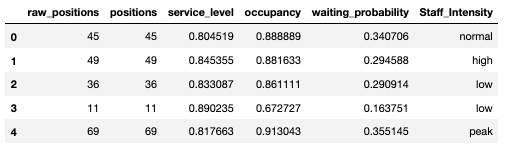


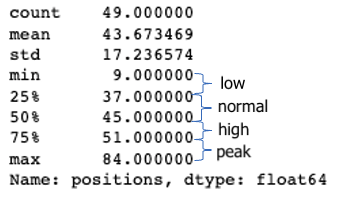

| category | Acceptable understaffing (%) |
| --- | --- |
| Peak | 20 |
| High | 15 |
| Normal | 10 |
| Low | 5 |

Given all the informations above, we proceed to solving the flexible integer programming model with the staffing level in first file. 

In [1]:
# This command imports the Gurobi functions and classes.

import gurobipy as gp
from gurobipy import GRB

from pyworkforce.queuing import ErlangC
from pyworkforce.queuing import MultiErlangC

import numpy as np
import pandas as pd
from pylab import *
import matplotlib
import matplotlib.pyplot as plt
import datetime
import re
import itertools
from itertools import repeat
import seaborn as sns

In [2]:
%store -r volume
%store -r staffing_level
%store -r slots
%store -r timeInterval
t = dict(zip(slots,staffing_level))

In [3]:
#Erlang C model

param_grid = {"transactions": [s for s in volume], "aht": [3], "interval": [15], "asa": [20 / 60]}
multi_erlang = MultiErlangC(param_grid=param_grid, n_jobs=-1)

required_positions_scenarios = {"service_level": [0.8]}

p = multi_erlang.required_positions(required_positions_scenarios)

erl = pd.DataFrame.from_dict(p)

In [4]:
label = ['low', 'normal', 'high', 'peak']
intervals = [9,37,45,51,84]

In [5]:
erl['Staff_Intensity'] = pd.cut(erl['positions'], intervals, labels=label)
erl.head()

,raw_positions,positions,service_level,occupancy,waiting_probability,Staff_Intensity
0,45,45,0.804519,0.888889,0.340706,normal
1,49,49,0.845355,0.881633,0.294588,high
2,36,36,0.833087,0.861111,0.290914,low
3,11,11,0.890235,0.672727,0.163751,low
4,69,69,0.817663,0.913043,0.355145,peak


In [6]:
# defining the upper bounds

ub1 = dict()
for i in range(49):
    if (erl['Staff_Intensity'][i] == 'peak'):
       ub1[slots[i]] = int(0.2*staffing_level[i])
    elif (erl['Staff_Intensity'][i] == 'high'):
       ub1[slots[i]] = int(0.15*staffing_level[i])
    elif (erl['Staff_Intensity'][i] == 'normal'):
       ub1[slots[i]] = int(0.1*staffing_level[i])
    else:
       ub1[slots[i]] = int(0.05*staffing_level[i])

In [7]:
timeSlots, staffing_levels = gp.multidict(t)
available_shifts, cost = gp.multidict({"shift1": 72, "shift2": 96, "shift3": 112})
available_shifts, duration = gp.multidict({"shift1": 4, "shift2": 6, "shift3": 8})

In [8]:
matr = []
for i in slots:
    for j in available_shifts:
        matr.append((i, j))

slot_shifts = gp.tuplelist(matr)

In [9]:
m = gp.Model("call_center_WFM_3")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-03


In [10]:
#binary constraint
a_tj = m.addVars(slot_shifts, vtype=GRB.BINARY, name="a_tj")

#Understaffing variables
underStaff = m.addVars(timeSlots, ub=ub1, vtype=GRB.INTEGER, name='U') 

#overstaffing variables 
overStaff = m.addVars(timeSlots, vtype=GRB.INTEGER, name='O')

#available shifts 
actualAgent = m.addVars(available_shifts, vtype=GRB.INTEGER, name='X')

#constraints 1: staffing constraint
shift_reqmts = m.addConstrs((gp.quicksum(a_tj[t,j]*actualAgent[j] for j in available_shifts) +
                             underStaff[t] - overStaff[t] == staffing_levels[t] for t in timeSlots),
                             name = 'staffing_levels')

#constraint 2: Time constraint
Shift_bounds = m.addConstrs((gp.quicksum(a_tj[t,j] for t in timeSlots) 
                                         <= 4*duration[j] for j in available_shifts), 
                                            name = 'Time_bound')

#understaffing constraint
shortfall = m.addConstr((gp.quicksum(underStaff) <= 0.05*gp.quicksum(staffing_levels)), 
                        name = 'shortFall')


In [11]:
#objective function: to minimize agents' salary
obj = gp.quicksum(actualAgent[j]*cost[j] for j in available_shifts)
m.setObjective(obj , GRB.MINIMIZE)

#set running time to 300secs
m.setParam(GRB.Param.TimeLimit, 300)

#output the problem in gurobi .lp format
m.write('call_center_3.lp')

#optimize the model
m.optimize()

Set parameter TimeLimit to value 300
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4 rows, 248 columns and 196 nonzeros
Model fingerprint: 0xe3e527ae
Model has 49 quadratic constraints
Variable types: 0 continuous, 248 integer (147 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [7e+01, 1e+02]
  Bounds range     [1e+00, 2e+01]
  RHS range        [2e+01, 1e+02]
  QRHS range       [9e+00, 8e+01]
Presolve removed 0 rows and 7 columns
Presolve time: 0.00s
Presolved: 347 rows, 682 columns, 1162 nonzeros
Presolved model has 294 SOS constraint(s)
Variable types: 0 continuous, 682 integer (300 binary)

Root relaxation: objective 4.896000e+03, 307 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj

Shifts Requirement
    Shift  Number of agents
0  shift1              23.0
1  shift2              15.0
2  shift3              43.0


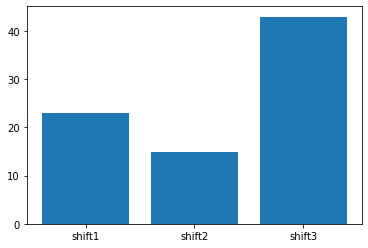

--------------------------------------------------
Shifts distribution
Symbols: '-': not covering, '*': covering
   Time slots shift1 shift2 shift3
0       slot1      -      -      *
1       slot2      -      -      *
2       slot3      *      *      -
3       slot4      -      *      -
4       slot5      *      -      *
5       slot6      -      *      *
6       slot7      -      -      *
7       slot8      -      -      *
8       slot9      *      *      *
9      slot10      *      *      -
10     slot11      -      *      -
11     slot12      -      -      *
12     slot13      -      -      *
13     slot14      *      -      *
14     slot15      -      -      *
15     slot16      -      *      *
16     slot17      -      *      *
17     slot18      -      *      -
18     slot19      -      -      *
19     slot20      -      -      *
20     slot21      -      -      *
21     slot22      -      -      *
22     slot23      *      *      -
23     slot24      *      *      -
24     slot2

In [12]:
solution = {}
shifts_sol = {}
assignments_all = {}
gant={}

assignments = dict()
for [w, s] in list(slot_shifts):
    if a_tj[w, s].x == 1:
        if w in assignments:
            assignments[w].append(s)
        else:
            assignments[w] = [s]

for s in available_shifts:
    shifts_sol[s]=actualAgent[s].X
    
for t in slots:
    assignments_all[t]=assignments.get(t, [])

print('Shifts Requirement')
print(pd.DataFrame.from_records(list(shifts_sol.items()), columns=['Shift', 'Number of agents']))


shiftVar = [str("X[shift{0}]".format(i)) for i in range(1,4)]
varInfo = [(v.varName, v.X) for v in m.getVars() if v.X > 0 and v.varname in shiftVar]
val = [a[1] for a in varInfo]

plt.bar(available_shifts[0:], val)
plt.show()


###########################################
print('-'*50)
for w in assignments_all:
    gant[w] = [w]
    for d in available_shifts:
        gant[w].append('*' if d in assignments_all[w] else '-')
        
print('Shifts distribution')
print('Symbols: \'-\': not covering, \'*\': covering')
print(pd.DataFrame.from_records(list(gant.values()), columns=['Time slots']+available_shifts))

#########################
print('-'*50)
print('optimal cost')
print(m.ObjVal)

In [13]:
a_ij = [str("a_tj[slot{0},shift{1}]".format(i,j)) for i in range(1,50) for j in range(1,4)]

aij_Info = [(v.varName, v.X) for v in m.getVars() if v.X > 0 and v.varname in a_ij]

x = [a[0] for a in aij_Info]

Total_staff_3 = list(itertools.repeat(0,49))
staff_sum = 0
for p in range(1,50):
    for q in range(1,4):
        if str("a_tj[slot{0},shift{1}]".format(p,q)) in x:
           Total_staff_3[p-1] += int(val[q-1])  

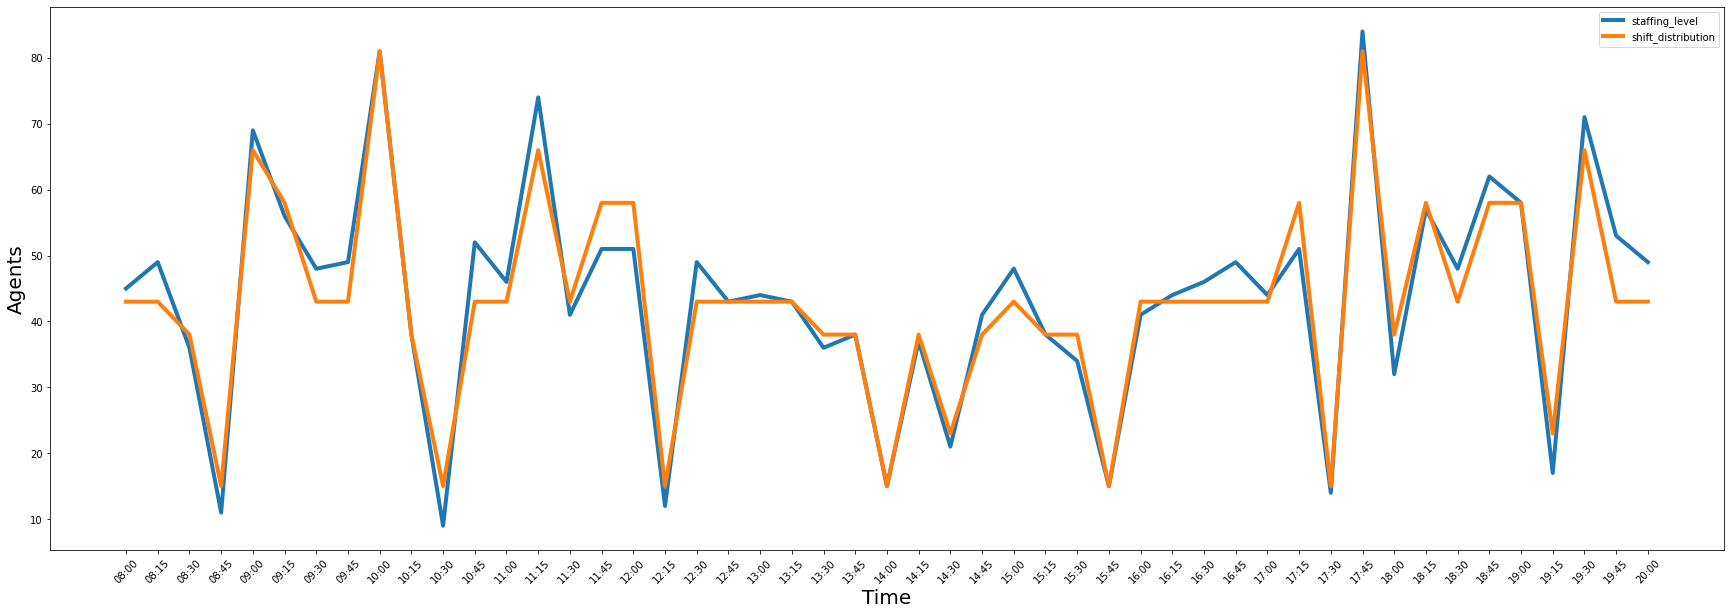

In [14]:
fig = plt.figure()
fig.set_size_inches(30,10)

plt.plot(timeInterval, staffing_level,linewidth = 4, label='staffing_level');
plt.plot(timeInterval, Total_staff_3,linewidth = 4, label='shift_distribution');

plt.xlabel('Time', fontsize=20)
plt.ylabel('Agents', fontsize=20)
plt.rc('ytick', labelsize=20)
plt.xticks(rotation=45);
plt.legend();

Mean of achieved service level
0.6411009633715352


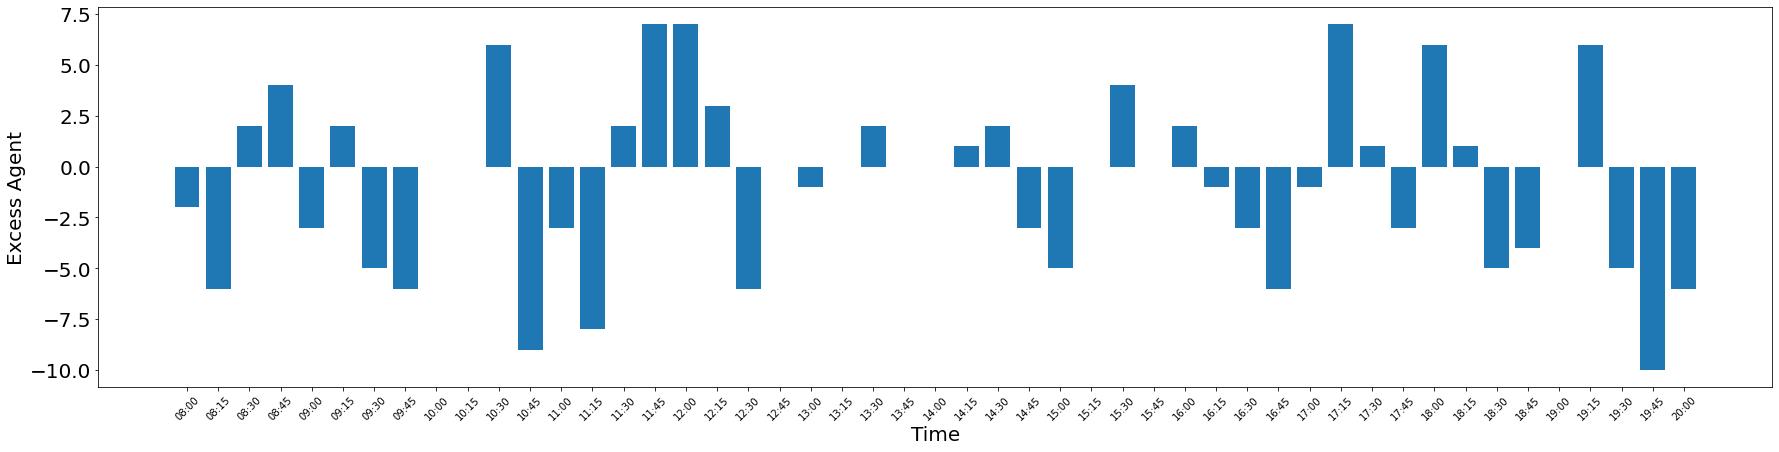

In [15]:
diff = np.array(Total_staff_3) - np.array(staffing_level)

new_SL_3 =[]
for i in range(1,50):
    erlang = ErlangC(transactions=volume[i], aht=3, interval=15, asa=20/60)
    achieved_service_level = erlang.service_level(positions=Total_staff_3[i-1])
    new_SL_3.append(achieved_service_level)

print('Mean of achieved service level')
print(mean(new_SL_3))


fig = plt.figure()
fig.set_size_inches(30,7)

plt.bar(timeInterval, diff.tolist())
plt.xlabel('Time', fontsize=20)
plt.ylabel('Excess Agent', fontsize=20)
plt.xticks(rotation=45);


This method schedules less agents when compared with the previous two methods. Again, it is worth noticing that, at some periods, the distribution equals the initial staffing levels while few/some periods are over/understaffed. Figure above depicts how under/overstaffing occurs, the bars having negative values indicate understaffing while those corresponding to positive values show overstaffing. Lastly, the periods without bars show balance. However, the method achieved service level mean of 64% in 20 secs.

# Performance Comparison

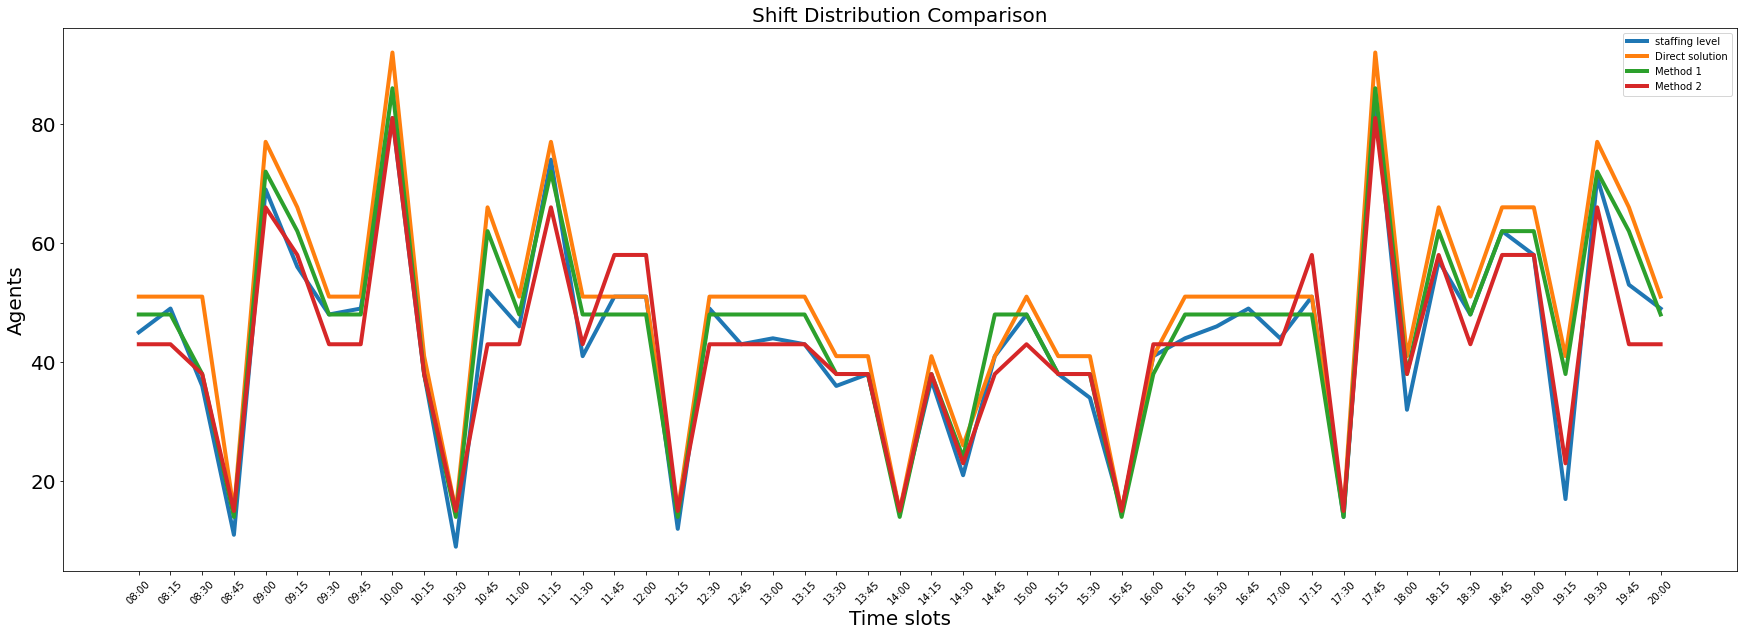

In [16]:
%store -r Total_staff
%store -r Total_staff_2

fig = plt.figure()
fig.set_size_inches(30,10)

plt.plot(timeInterval, staffing_level, linewidth = 4, label= 'staffing level')
plt.plot(timeInterval, Total_staff, linewidth = 4, label='Direct solution')
plt.plot(timeInterval, Total_staff_2, linewidth = 4, label='Method 1')
plt.plot(timeInterval, Total_staff_3, linewidth = 4, label='Method 2')


plt.xlabel('Time slots', fontsize=20)
plt.ylabel('Agents', fontsize=20)
plt.title('Shift Distribution Comparison',fontsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.xticks(rotation=45)
plt.legend();

| Methods | Number of Agents assigned | Excess schedule | Cost (€) |
|---|---|---|---|
| Direct | 92 | 268 | €9024 |
| 1st approach | 86 | 116 | €8448 |
| Flexible model | 81 | -36 | €7912 |

# Conclusion

The staffing and scheduling of a flexible call center has been investigated using queuing theory and integer programming. Particular attention is being paid to the impact of integer programming and queuing theory on optimizing staffing levels in relation to total operating cost of the call center. The staffing and scheduling of call centers has always been done using integer programming. We were able to establish that this method frequently results in overstaffing due to the constrictive nature of service level, hence the need for some flexibility.<br>
After incorporating some flexibility into our model, we can safely conclude that capacity planning in call centers is better accomplished by integrating queueing models (Erlang C) and integer programming (IP) rather than leaving IP with the sole responsibility of covering the staffing requirements determined by Erlang at the lowest possible cost.